<a href="https://colab.research.google.com/github/HalgasAdrian/CS5230-Coursework/blob/main/HW2B%20Clustering%20DBSCAN%2C%20Hierarchical%20Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**PROBLEM 5: DBSCAN on toy-neighborhood data**

You are to cluster, and visualize, a small dataset using DBSCAN epsilon = 7.5, MinPts = 3). You have been provided a file, dbscan.csv, that has the following columns for each point in the dataset:

cluster originally empty, provided for your convenience pt a unique id for each data point

x point x-coordinate

y point y-coordinate

num neighbors number of neighbors, according to the coordinates above neighbors the id’s of all neighbors within

As you can see, a tedious O(n^2) portion of the work has been done for you. Your job is to execute, point-by-point, the DBSCAN algorithm, logging your work.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display

In [ ]:
# Loading data
url = 'https://www.ccs.neu.edu/home/vip/teach/DMcourse/2_cluster_EM_mixt/HW2/dbscan.csv'
data = pd.read_csv(url)
print(data.head())

# Convert to NumPy array
numeric_data = data.select_dtypes(include=['number']).to_numpy()
print(f"Numeric data shape: {numeric_data.shape}")

   cluster  pt          x          y  num_neighbors neighbors
0      NaN   0  51.418089  13.593610              2      0,27
1      NaN   1  39.132318  -4.419204              3   1,40,75
2      NaN   2  47.807515 -25.822561              1         2
3      NaN   3  27.699703  53.434193              1         3
4      NaN   4  39.860995   5.676871              3   4,56,75
Numeric data shape: (80, 5)


In [ ]:
# Initialize DBSCAN Parameters
epsilon = 7.5
minPts = 3

# Define Cluster Labels
cluster_assignments = {}

# Cluster tracking
current_cluster = 0
noise = 0

# Convert NaN cluster values to None
data['cluster'] = None

In [ ]:
# Function to expand a cluster recursively
def expand_cluster(point_index, cluster_id):
    """
    Expands a given cluster by checking the neighbors and
    adding core points to the cluster.
    """
    neighbors_to_visit = data.loc[point_index, 'neighbors']

    if isinstance(neighbors_to_visit, str):
        neighbors_to_visit = list(map(int, neighbors_to_visit.split(',')))

    while neighbors_to_visit:
        neighbor_id = neighbors_to_visit.pop()
        neighbor_index = data.index[data['pt'] == neighbor_id].tolist()[0]

        if data.at[neighbor_index, 'cluster'] is None:
            data.at[neighbor_index, 'cluster'] = cluster_id

            num_neighbors = data.at[neighbor_index, 'num_neighbors']
            if num_neighbors >= minPts:
                more_neighbors = data.at[neighbor_index, 'neighbors']
                if isinstance(more_neighbors, str):
                    more_neighbors = list(map(int, more_neighbors.split(',')))
                    neighbors_to_visit.extend(more_neighbors)

In [ ]:
# DBSCAN Algorithm
for index, row in data.iterrows():
    if data.at[index, 'cluster'] is not None:
        continue

    num_neighbors = row['num_neighbors']

    if num_neighbors < minPts:
        data.at[index, 'cluster'] = noise
    else:
        current_cluster += 1
        data.at[index, 'cluster'] = current_cluster
        expand_cluster(index, current_cluster)

display(data)

,cluster,pt,x,y,num_neighbors,neighbors
0,0,0,51.418089,13.593610,2,"0,27"
1,1,1,39.132318,-4.419204,3,"1,40,75"
2,0,2,47.807515,-25.822561,1,2
3,0,3,27.699703,53.434193,1,3
4,1,4,39.860995,5.676871,3,"4,56,75"
...,...,...,...,...,...,...
75,1,75,39.659047,0.230178,3,"1,4,75"
76,2,76,26.366491,8.798826,3,"21,49,76"
77,0,77,-36.184060,44.292045,2,"55,77"
78,3,78,44.012085,37.729478,3,"9,33,78"


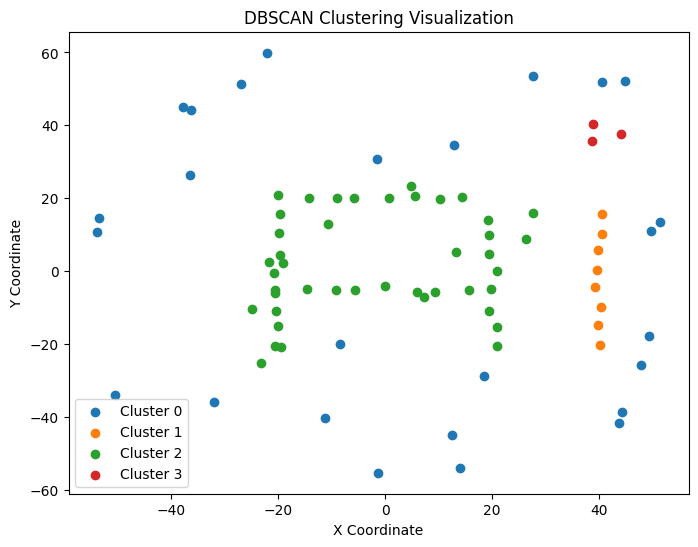

In [ ]:
# Scatter plot of clusters
plt.figure(figsize=(8,6))

# Plot each cluster with a different color
for cluster_id in data['cluster'].unique():
    cluster_points = data[data['cluster'] == cluster_id]
    plt.scatter(cluster_points['x'], cluster_points['y'], label=f"Cluster {cluster_id}")

# Formatting
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('DBSCAN Clustering Visualization')
plt.legend()
plt.show()

**PROBLEM 6: DBSCAN on toy raw data**

Three toy 2D datasets are provided (or they can be obtained easily with scikit learn) circles; blobs, and moons. Run your own implementation of DBSCAN on these, in two phases.


In [ ]:
# Start with generating our datasets
from sklearn.datasets import make_circles, make_blobs, make_moons

# Synthetic datasets
datasets = {
    'Circles': make_circles(n_samples=300, noise=0.05, factor=0.5, random_state=42),
    'Blobs': make_blobs(n_samples=300, centers=4, cluster_std=1.5, random_state=42),
    'Moons': make_moons(n_samples=300, noise=0.05, random_state=42)
}

In [ ]:
# DBSCAN Parameters for each dataset
dbscan_params = {
    "Circles": {"epsilon": 0.2, "minPts": 5},
    "Blobs": {"epsilon": 1.5, "minPts": 6},
    "Moons": {"epsilon": 0.2, "minPts": 5},
}

# DBSCAN Algorithm
def dbscan(X, epsilon, minPts):
    """
    DBSCAN Implementation for clustering 2D points.
    """
    clusters = np.full(X.shape[0], -1)  # Initialize all points as noise (-1)
    cluster_id = 0

    # Function to expand a cluster
    def expand_cluster(point_idx, cluster_id):
        neighbors = region_query(point_idx)
        if len(neighbors) < minPts:
            return False
        else:
            clusters[point_idx] = cluster_id
            queue = neighbors.copy()
            while queue:
                neighbor_idx = queue.pop()
                if clusters[neighbor_idx] == -1:
                    clusters[neighbor_idx] = cluster_id
                    new_neighbors = region_query(neighbor_idx)
                    if len(new_neighbors) >= minPts:
                        queue.extend(new_neighbors)
            return True

    # Function to find neighbors within epsilon radius
    def region_query(point_idx):
        distances = np.linalg.norm(X - X[point_idx], axis=1)
        return np.where(distances <= epsilon)[0].tolist()

    # Process each point
    for i in range(X.shape[0]):
        if clusters[i] != -1:
            continue
        if expand_cluster(i, cluster_id):
            cluster_id += 1

    return np.array(clusters)

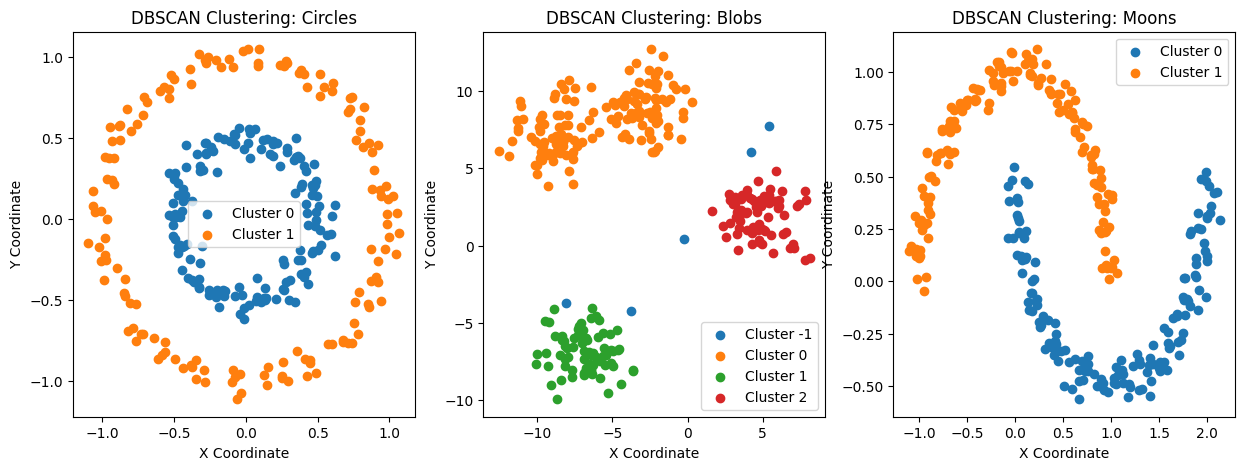

In [ ]:
# Apply DBSCAN to Each Dataset
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, (name, (X, _)) in enumerate(datasets.items()):
    params = dbscan_params[name]
    labels = dbscan(X, params["epsilon"], params["minPts"])
    unique_clusters = np.unique(labels)

    # Plot Clusters
    plt.subplot(1, 3, i + 1)
    for cluster in unique_clusters:
        cluster_points = X[labels == cluster]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster}")

    # Plot Formatting
    plt.title(f"DBSCAN Clustering: {name}")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.legend()

plt.show()

**PROBLEM 7: DBSCAN on real data**

Run the DBSCAN algorithm on the 20NG dataset, and on the FASHION dataset, and the HouseHold dataset (see papers), and evaluate results. You need to implement both phases (1) neighborhoods creation, (2) DBSCAN.

Explain why/when it works, and speculate why/when not. You need to trial and error for parameters epsilon and MinPts

EXTRA CREDIT: Using class labels (cheating), try to remove/add points in curate the set for better DBSCAN runs

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.datasets import fetch_20newsgroups
from sklearn.neighbors import NearestNeighbors
from tensorflow.keras.datasets import fashion_mnist
from sklearn.metrics import silhouette_score
import urllib.request
import zipfile

# Enable GPU Acceleration for Fashion-MNIST
tf.config.list_physical_devices('GPU')

[]

Note on TF-IDF Vectorization: Term Frequency-Inverse Document Frequency is a text representation technique that evaluates how importat a word is to a document relative to a corpus.

Term Frequency (TF) = (word count in doc) / (total words in doc) - measures local importance of a word

Inverse document frequency (IDF) = log(total docs / docs containing word) - penalizes words common across many docs

TF-IDF = TF * IDF - final importance score for each word

TfidVectorizer automatically applies L2 Normalization to our output vectors.

In [12]:
print("Loading 20 Newsgroups dataset...")
newsgroups = fetch_20newsgroups(subset="all", remove=("headers", "footers", "quotes"))

# Convert text to numerical features using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X_20ng = vectorizer.fit_transform(newsgroups.data).toarray()

# Normalize the dataset
X_20ng = StandardScaler().fit_transform(X_20ng)

print(f"20 Newsgroups dataset shape: {X_20ng.shape}")

Loading 20 Newsgroups dataset...
20 Newsgroups dataset shape: (18846, 5000)


In [13]:
print("Loading Fashion-MNIST dataset...")
(X_train, _), (_, _) = fashion_mnist.load_data()

# Flatten images and normalize
X_fashion = X_train.reshape(X_train.shape[0], -1) / 255.0

print(f"Fashion-MNIST dataset shape: {X_fashion.shape}")

Loading Fashion-MNIST dataset...
29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Fashion-MNIST dataset shape: (60000, 784)


In [14]:
# Download dataset
urllib.request.urlretrieve(
    "https://archive.ics.uci.edu/static/public/235/individual+household+electric+power+consumption.zip",
    "household_power_data.zip"
)

# Extract dataset
with zipfile.ZipFile("household_power_data.zip", "r") as zip_ref:
    zip_ref.extractall()

# Load dataset
file_path = "household_power_consumption.txt"
household_data = pd.read_csv(
    file_path, sep=";", low_memory=False, na_values="?",
    parse_dates={"Datetime": ["Date", "Time"]}, infer_datetime_format=True
)

# Drop rows with missing values
household_data.dropna(inplace=True)

# Select relevant numerical columns
features = ["Global_active_power", "Global_reactive_power", "Voltage",
            "Global_intensity", "Sub_metering_1", "Sub_metering_2", "Sub_metering_3"]

X_household = household_data[features].values

# Normalize the dataset
X_household = StandardScaler().fit_transform(X_household)

print(f"Household Power dataset shape: {X_household.shape}")

<ipython-input-14-5f8e8be61260>:13: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  household_data = pd.read_csv(
<ipython-input-14-5f8e8be61260>:13: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  household_data = pd.read_csv(
<ipython-input-14-5f8e8be61260>:13: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  household_data = pd.read_csv(


Household Power dataset shape: (2049280, 7)


In [25]:
# Apply Random Sampling to Reduce Dataset Size
def sample_data(X, sample_size=20000):
    """Randomly sample a subset of data for faster DBSCAN"""
    if X.shape[0] > sample_size:
        indices = np.random.choice(X.shape[0], size=sample_size, replace=False)
        return X[indices]
    return X

# Sample Household Data
X_household_sampled = sample_data(X_household, sample_size=5000)
X_20ng_sampled = sample_data(X_20ng, sample_size=5000)
X_fashion_sampled = sample_data(X_fashion, sample_size=5000)

print(f"Sampled Household dataset shape: {X_household_sampled.shape}")
print(f"Sampled 20NG dataset shape: {X_20ng_sampled.shape}")
print(f"Sampled Fashion dataset shape: {X_fashion_sampled.shape}")

Sampled Household dataset shape: (5000, 7)
Sampled 20NG dataset shape: (5000, 5000)
Sampled Fashion dataset shape: (5000, 784)


Notes on DBSCAN:

DBSCAN works well if clusters have different densities, has natural clusters within the data, and works best when we chose the most optimal epsilon value.

DBSCAN fails on high dimensional data, like on the 20NG dataset, it will also fail if our epsilon is too high because it will only make one cluster. DBSCAN will also fail if our MinPts is too low because we will make a bunch of small clusters.

After attempting a brute force approach with 20NG and seeing an extremely high runtime, I have decided to implement some optimization to hopefully bring that runtime down.

Here is what I have done to optimize DBSCAN on real world data:


1.   Replaced brute force method with BallTree Nearest Neighbors - Ball tree organizes the data into spheres, allowing for efficient identification of data points close to a given search point. Quickly eliminating large portions of data far away from our search.
2.   Enabled GPU-Acceleration for Fashion-MNIST
3.   Normalization for household power consumption
4.   Will use sampling for all 3 datasets.



In [26]:
from sklearn.neighbors import BallTree

def optimized_dbscan(X, epsilon, minPts):
    """
    Optimized DBSCAN Implementation using BallTree for neighbor search.
    """
    num_points = X.shape[0]
    clusters = np.full(num_points, -1)
    cluster_id = 0

    # Use BallTree instead of KD-Tree for better high-dimensional performance
    tree = BallTree(X)
    neighbors_dict = {i: tree.query_radius(X[i].reshape(1, -1), r=epsilon)[0] for i in range(num_points)}

    def expand_cluster(point_idx, cluster_id):
        """
        Expands the cluster by iterating through reachable points.
        """
        if len(neighbors_dict[point_idx]) < minPts:
            return False
        else:
            clusters[point_idx] = cluster_id
            queue = set(neighbors_dict[point_idx])

            while queue:
                neighbor_idx = queue.pop()
                if clusters[neighbor_idx] == -1:
                    clusters[neighbor_idx] = cluster_id
                    if len(neighbors_dict[neighbor_idx]) >= minPts:
                        queue.update(neighbors_dict[neighbor_idx])

            return True

    # Process each point
    for i in range(num_points):
        if clusters[i] != -1:
            continue
        if expand_cluster(i, cluster_id):
            cluster_id += 1

    return clusters

In [27]:
def run_dbscan(X, dataset_name, epsilon, minPts):
    print(f"\nRunning DBSCAN on {dataset_name}...")

    # Run custom DBSCAN with optimized neighbor search
    clusters = optimized_dbscan(X, epsilon, minPts)

    # Count number of clusters
    num_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
    print(f"DBSCAN found {num_clusters} clusters in {dataset_name}")

    # Compute Silhouette Score (Only if there is more than 1 cluster)
    if num_clusters > 1:
        score = silhouette_score(X, clusters)
        print(f"Silhouette Score for {dataset_name}: {score:.4f}")

    # Count number of points per cluster
    unique, counts = np.unique(clusters, return_counts=True)
    cluster_counts = dict(zip(unique, counts))
    print(f"Cluster Sizes in {dataset_name}: {cluster_counts}")

    return clusters

Tuning our DBSCAN parameters:

If too many clusters → Increase minPts (prevents small noise clusters).

If too few clusters → Decrease ε (forces DBSCAN to detect more clusters).

If clusters merge too much → Lower ε gradually.

In [28]:
# Define DBSCAN parameters for each dataset
dbscan_params = {
    "20NG": {"epsilon": 0.3, "minPts": 6},
    "Fashion-MNIST": {"epsilon": 3.15, "minPts": 5},
    "Household": {"epsilon": 0.7, "minPts": 10},
}

datasets = {
    "20NG": X_20ng_sampled,
    "Fashion-MNIST": X_fashion_sampled,
    "Household": X_household_sampled
}

for dataset_name, params in dbscan_params.items():
    run_dbscan(datasets[dataset_name], dataset_name, params["epsilon"], params["minPts"])


Running DBSCAN on 20NG...
DBSCAN found 1 clusters in 20NG
Cluster Sizes in 20NG: {-1: 4875, 0: 125}

Running DBSCAN on Fashion-MNIST...
DBSCAN found 16 clusters in Fashion-MNIST
Silhouette Score for Fashion-MNIST: -0.3190
Cluster Sizes in Fashion-MNIST: {-1: 4463, 0: 73, 1: 257, 2: 13, 3: 21, 4: 61, 5: 8, 6: 16, 7: 18, 8: 5, 9: 14, 10: 12, 11: 7, 12: 6, 13: 14, 14: 6, 15: 6}

Running DBSCAN on Household...
DBSCAN found 3 clusters in Household
Silhouette Score for Household: 0.2177
Cluster Sizes in Household: {-1: 456, 0: 4510, 1: 21, 2: 13}


EXTRA CREDIT: Using class labels (cheating), try to remove/add points in curate the set for better DBSCAN runs


1. Remove rare classes from FASHION
2. Select only a subset of topics from 20NG
3. Remove extreme power usage outliers from household data

In [29]:
# Load Fashion-MNIST dataset
(X_train, y_train), (_, _) = fashion_mnist.load_data()

# Select specific classes (T-shirt, Trouser, Sandal, Sneaker, Ankle boot)
keep_classes = [0, 1, 5, 7, 9]
mask = np.isin(y_train, keep_classes)

# Flatten images and normalize
X_fashion_filtered = X_train[mask].reshape(-1, 784) / 255.0

print(f"Filtered Fashion-MNIST dataset shape: {X_fashion_filtered.shape}")

Filtered Fashion-MNIST dataset shape: (30000, 784)


In [30]:
# Load dataset with class labels
X_20ng, y_20ng = fetch_20newsgroups(subset="all", remove=("headers", "footers", "quotes"), return_X_y=True)

# Select specific topics (Electronics, Space, Cryptography, Religion)
keep_topics = [4, 11, 15, 18]
mask = np.isin(y_20ng, keep_topics)

# Extract and preprocess text data using TF-IDF
X_20ng_filtered_texts = np.array(X_20ng)[mask]
vectorizer = TfidfVectorizer(max_features=5000)
X_20ng_filtered = vectorizer.fit_transform(X_20ng_filtered_texts).toarray()

# Normalize the dataset
X_20ng_filtered = StandardScaler().fit_transform(X_20ng_filtered)

print(f"Filtered 20NG dataset shape: {X_20ng_filtered.shape}")

Filtered 20NG dataset shape: (3726, 5000)


In [31]:
# Compute quartiles and remove extreme power outliers
q1 = household_data[features].quantile(0.25)
q3 = household_data[features].quantile(0.75)
iqr = q3 - q1

# Define lower & upper bounds for outlier removal
lower_bound = q1 - 1.2 * iqr
upper_bound = q3 + 1.2 * iqr

# Apply filter to remove outliers
mask = (household_data[features] >= lower_bound) & (household_data[features] <= upper_bound)
household_filtered = household_data[features][mask.all(axis=1)]

# Sample 50,000 rows for processing
X_household_filtered = household_filtered.sample(n=50000, random_state=42).to_numpy()

# Normalize the dataset
X_household_filtered = StandardScaler().fit_transform(X_household_filtered)

print(f"Filtered Household dataset shape: {X_household_filtered.shape}")

Filtered Household dataset shape: (50000, 7)


In [34]:
# Sample Household Data
X_household_sampled_filtered = sample_data(X_household_filtered, sample_size=5000)
X_20ng_sampled_filtered = sample_data(X_20ng_filtered, sample_size=5000)
X_fashion_sampled_filtered = sample_data(X_fashion_filtered, sample_size=5000)

print(f"Sampled Household dataset shape: {X_household_sampled.shape}")
print(f"Sampled 20NG dataset shape: {X_20ng_filtered.shape}")
print(f"Sampled Fashion dataset shape: {X_fashion_sampled.shape}")

Sampled Household dataset shape: (5000, 7)
Sampled 20NG dataset shape: (3726, 5000)
Sampled Fashion dataset shape: (5000, 784)


In [38]:
# Store datasets for DBSCAN
datasets_filtered = {
    "20NG": X_20ng_sampled_filtered,
    "Fashion-MNIST": X_fashion_sampled_filtered,
    "Household": X_household_sampled_filtered
}

# Define DBSCAN parameters for each dataset
dbscan_params = {
    "20NG": {"epsilon": 0.5, "minPts": 4},
    "Fashion-MNIST": {"epsilon": 2.9, "minPts": 10},
    "Household": {"epsilon": 0.7, "minPts": 10},
}

# Run DBSCAN for each dataset
for dataset_name, X in datasets_filtered.items():
    print(f"\nRunning DBSCAN on {dataset_name} with ε={dbscan_params[dataset_name]['epsilon']}, minPts={dbscan_params[dataset_name]['minPts']}")
    clusters = run_dbscan(X, dataset_name, dbscan_params[dataset_name]["epsilon"], dbscan_params[dataset_name]["minPts"])


Running DBSCAN on 20NG with ε=0.3, minPts=6

Running DBSCAN on 20NG...
DBSCAN found 1 clusters in 20NG
Cluster Sizes in 20NG: {-1: 3618, 0: 108}

Running DBSCAN on Fashion-MNIST with ε=3.15, minPts=5

Running DBSCAN on Fashion-MNIST...
DBSCAN found 13 clusters in Fashion-MNIST
Silhouette Score for Fashion-MNIST: -0.2786
Cluster Sizes in Fashion-MNIST: {-1: 3793, 0: 670, 1: 219, 2: 223, 3: 3, 4: 5, 5: 35, 6: 7, 7: 10, 8: 8, 9: 12, 10: 7, 11: 6, 12: 2}

Running DBSCAN on Household with ε=0.7, minPts=10

Running DBSCAN on Household...
DBSCAN found 7 clusters in Household
Silhouette Score for Household: 0.2413
Cluster Sizes in Household: {-1: 411, 0: 2557, 1: 979, 2: 174, 3: 576, 4: 233, 5: 57, 6: 13}


Expected results:

20NG approx 10

FASHION approx 8-10

Household apporox 8

**PROBLEM 8: Hierarchical Clustering**

Implement hierarchical clustering. Start the bottom of the hierarchy with all point (or at least 5000 sampled) and build the hierarchy by repeatedly "joining the closest" clusters with avg_dist or single_dist criteria up to one big cluster (full hierarchy). Then decide how to cut it for K=2 or K=5 or K=10 clusters and evaluate. Run on moons dataset.



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from scipy.spatial.distance import pdist, squareform

# Generate Moons dataset
X, _ = make_moons(n_samples=5000, noise=0.05, random_state=42)

print(f"Moons dataset shape: {X.shape}")

Moons dataset shape: (5000, 2)


In [2]:
import heapq
from scipy.spatial.distance import pdist, squareform

class HierarchicalClusteringOptimized:
    def __init__(self, linkage="average"):
        """
        Optimized Hierarchical Clustering using a priority queue (heap).

        Parameters:
        - linkage: "single" (minimum distance) or "average" (mean distance).
        """
        self.linkage = linkage
        self.clusters = None
        self.distances = None

    def fit(self, X):
        """
        Performs Optimized Hierarchical Clustering on dataset X.
        """
        n_samples = X.shape[0]
        self.clusters = {i: [i] for i in range(n_samples)}

        # Compute all pairwise distances once
        self.distances = squareform(pdist(X, metric="euclidean"))

        # Initialize priority queue (heap) with all distances
        heap = []
        for i in range(n_samples):
            for j in range(i + 1, n_samples):
                heapq.heappush(heap, (self.distances[i, j], i, j))

        merge_order = []

        while len(self.clusters) > 1:
            # Get the closest two clusters (smallest distance from heap)
            _, c1, c2 = heapq.heappop(heap)

            if c1 not in self.clusters or c2 not in self.clusters:
                continue

            # Merge clusters
            self.clusters[c1].extend(self.clusters[c2])
            del self.clusters[c2]

            # Store merge history
            merge_order.append((c1, c2))

            # Update heap with new distances for the merged cluster
            for c3 in list(self.clusters.keys()):
                if c3 == c1:
                    continue

                # Compute new distance based on linkage
                if self.linkage == "single":
                    new_dist = np.min([self.distances[p1, p2] for p1 in self.clusters[c1] for p2 in self.clusters[c3]])
                elif self.linkage == "average":
                    new_dist = np.mean([self.distances[p1, p2] for p1 in self.clusters[c1] for p2 in self.clusters[c3]])

                heapq.heappush(heap, (new_dist, c1, c3))

        return merge_order

In [3]:
# Run hierarchical clustering with Average-Linkage
h_clust = HierarchicalClusteringOptimized(linkage="average")
merge_history = h_clust.fit(X)

print(f"Final number of clusters: {len(h_clust.clusters)}")

Final number of clusters: 1


In [4]:
def get_clusters_at_k_fixed(merge_history, n_samples, k):
    """
    Extracts clusters when there are exactly 'k' clusters remaining.

    Fix: Adjusted to handle two-element tuples instead of three.
    """
    clusters = {i: [i] for i in range(n_samples)}

    for c1, c2 in merge_history:
        if len(clusters) == k:
            break
        clusters[c1].extend(clusters[c2])
        del clusters[c2]

    # Assign cluster labels
    labels = np.full(n_samples, -1)
    for cluster_id, indices in clusters.items():
        labels[indices] = cluster_id

    return labels

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from scipy.cluster.hierarchy import fcluster
import scipy.cluster.hierarchy as sch

def plot_clusters(X, cluster_labels, title="Hierarchical Clustering Results"):
    plt.figure(figsize=(10, 6))

    # Get unique cluster labels and assign colors
    unique_clusters = np.unique(cluster_labels)
    num_clusters = len(unique_clusters)
    colors = plt.cm.get_cmap("tab10", num_clusters)

    # Plot each cluster with a different color
    for i, cluster in enumerate(unique_clusters):
        mask = cluster_labels == cluster
        plt.scatter(X[mask, 0], X[mask, 1],
                    label=f"Cluster {cluster}",
                    alpha=0.7, edgecolors="k", s=20,
                    color=colors(i / num_clusters))

    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend()
    plt.show()

<ipython-input-5-8cebed151b93>:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", num_clusters)


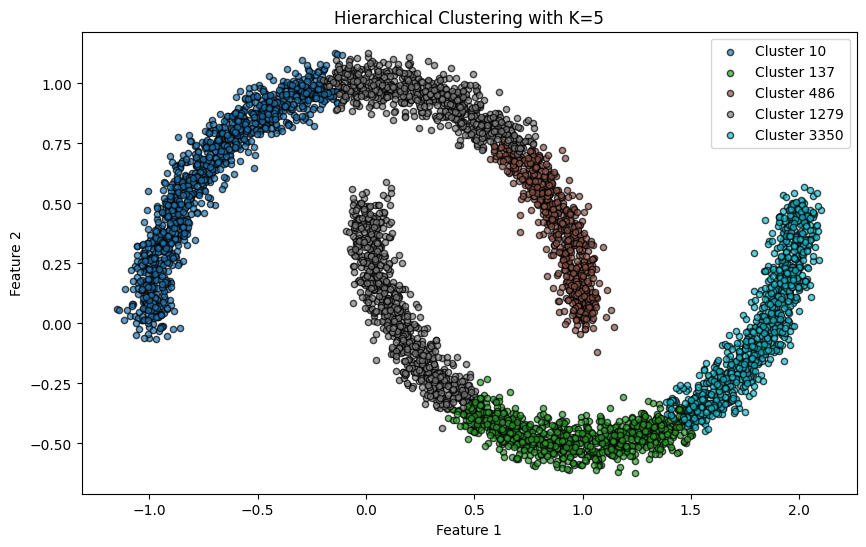

In [10]:
# Extract clusters directly from your computed merge history
k = 5
cluster_labels_fixed = get_clusters_at_k_fixed(merge_history, X.shape[0], k)

# Plot the results using hierarchical clustering output
plot_clusters(X, cluster_labels_fixed, title=f"Hierarchical Clustering with K={k}")

Clusters are assigned based on original data point indices.

In this hierarchical clustering, each data point starts as its own cluster.
When two clusters merge, the lower-index cluster absorbs the higher-index one.
The cluster labels you see correspond to the original indices of the surviving clusters.
Cluster labels represent the first merged index.

For example, if point 137 was the first in a merged group, that cluster is named Cluster 137.
If point 10 was the lowest index in another group, that cluster is called Cluster 10.

In [11]:
from sklearn.metrics import silhouette_score

# Evaluate different cluster cuts
for k in [2, 5, 10]:
    cluster_labels_fixed = get_clusters_at_k_fixed(merge_history, X.shape[0], k)
    score = silhouette_score(X, cluster_labels_fixed)
    print(f"Silhouette Score for K={k}: {score:.4f}")

Silhouette Score for K=2: 0.4157
Silhouette Score for K=5: 0.4330
Silhouette Score for K=10: 0.4362


Silhouette scores indicate "moderate" clustering quality.


In [12]:
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

In [13]:
def plot_dendrogram(X, method="average", title="Hierarchical Clustering Dendrogram"):
    """
    Plots the dendrogram for hierarchical clustering.

    Parameters:
    - X: The dataset used for clustering.
    - method: Linkage method ('single', 'complete', 'average', 'ward').
    - title: Title of the dendrogram plot.
    """
    plt.figure(figsize=(12, 6))

    # Compute linkage matrix
    linkage_matrix = sch.linkage(X, method=method)

    # Plot dendrogram
    sch.dendrogram(linkage_matrix, truncate_mode="level", p=20)
    plt.title(title)
    plt.xlabel("Data Points (Sample Index)")
    plt.ylabel("Distance (Linkage Height)")
    plt.show()

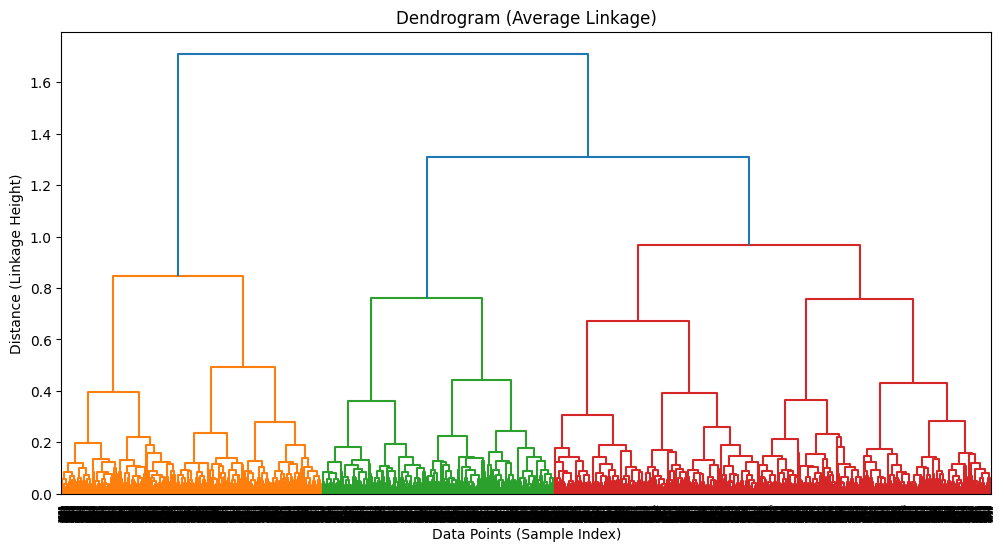

In [ ]:
plot_dendrogram(X, method="average", title="Dendrogram (Average Linkage)")

In [14]:
from scipy.cluster.hierarchy import fcluster

# Cut the dendrogram at a threshold distance of 0.5
cluster_labels = fcluster(sch.linkage(X, method="average"), t=0.5, criterion="distance")

print(f"Number of clusters found: {len(set(cluster_labels))}")

Number of clusters found: 8
